In [1]:
import datetime
import re
import string
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import (
    Input,
    Embedding,
    Dense,
    Concatenate,
    Dropout,
    GlobalAveragePooling2D,
    TextVectorization,
    GlobalAveragePooling1D,
)
from keras import optimizers, metrics, losses, Sequential
from keras.models import Model
from keras.utils import to_categorical
import pandas as pd
import numpy as np
from keras import utils
from sklearn.model_selection import train_test_split
from sklearn.calibration import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf

SEED = 123

images_path = "../../data/raw/images/image_train"

In [2]:
def plt_graph(training_history, run=None):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

    range_epochs = np.arange(1, len(training_history.epoch) + 1, 1)

    # Courbe de la précision sur l'échantillon d'entrainement
    ax1.plot(
        range_epochs,
        training_history.history["accuracy"],
        label="Training Accuracy",
        color="blue",
    )

    ax1.plot(
        range_epochs,
        training_history.history["val_accuracy"],
        label="Validation Accuracy",
        color="orange",
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")
    ax1.set_title("Training and Validation Accuracy")
    ax1.legend()

    # Courbe de la précision sur l'échantillon de test
    ax2.plot(
        range_epochs,
        training_history.history["loss"],
        label="Training Loss",
        color="blue",
    )
    ax2.plot(
        range_epochs,
        training_history.history["val_loss"],
        label="Validation Loss",
        color="orange",
    )
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.set_title("Training and Validation Loss")
    ax2.legend()

    if run != None:
        id_exp = str(run.info.run_id)
    else:
        id_exp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    # Affichage de la figure
    plt.savefig(f"reports/figures/{id_exp}_training_history_DNN.png")

In [3]:
df = pd.read_csv("../../data/raw/x_train.csv", index_col=0)
df_target = pd.read_csv("../../data/raw/y_train.csv", index_col=0)
df[df_target.columns[0]] = df_target

df["text"] = np.where(
    df["description"].isna(),
    df["designation"].astype(str),
    df["designation"].astype(str) + " " + df["description"].astype(str),
)

df["image_name"] = df.apply(
    lambda row: f"image_{row['imageid']}_product_{row['productid']}.jpg", axis=1
)
df["image_path"] = images_path + "/" + df["image_name"]

df.drop("designation", axis=1, inplace=True)
df.drop("description", axis=1, inplace=True)
df.drop("productid", axis=1, inplace=True)
df.drop("imageid", axis=1, inplace=True)
df.drop("image_name", axis=1, inplace=True)

num_classes = df["prdtypecode"].value_counts().shape[0]

target = df["prdtypecode"].astype("str")

# Séparation des données en ensembles d'entraînement et de test
# Text
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
    df["text"],
    target,
    test_size=0.2,
    random_state=SEED,
    stratify=df["prdtypecode"].values,
)
# Image
X_train_image, X_test_image, y_train_image, y_test_image = train_test_split(
    df["image_path"],
    target,
    test_size=0.2,
    random_state=SEED,
    stratify=df["prdtypecode"].values,
)

X_train_text = np.expand_dims(X_train_text, axis=1)
X_test_text = np.expand_dims(X_test_text, axis=1)

# Encode
le = LabelEncoder()
y_train_text = le.fit_transform(y_train_text)
y_test_text = le.transform(y_test_text)

# Vectorize
y_train_text = to_categorical(y_train_text, num_classes)
y_test_text = to_categorical(y_test_text, num_classes)

print("\ny_train shape:", y_train_text.shape)

y_train_1d = np.argmax(y_train_text, axis=1)

# Appliquer des poids aux classes selon l'équilibrage du dataset
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train_1d), y=y_train_1d
)

# Create a dictionary mapping class indices to their corresponding weights
class_weight_dict = dict(zip(np.unique(y_train_1d), class_weights))

# Défnit la longueur de la séquence du model
# Vocabulary size and number of words in a sequence.
# median = 320
# mean = 600
df["len"] = df["text"].str.len()
sequence_length = 5000
print("\nsequence_length:", sequence_length, "\n")

# Pour libérer de la RAM
del df, df_target, target

X_train_text = tf.strings.as_string(X_train_text)
X_test_text = tf.strings.as_string(X_test_text)


y_train shape: (67932, 27)

sequence_length: 5000 



2024-04-26 11:22:25.723863: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-04-26 11:22:25.723895: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-26 11:22:25.723903: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-26 11:22:25.723919: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-26 11:22:25.723930: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuration du générateur de données - Training set
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    shear_range=0.2,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

# Configuration du générateur de données - Validation set
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Préparation des générateurs
X_train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train_image.to_frame(name="image_path").join(
        y_train_image.to_frame(name="prdtypecode")
    ),
    x_col="image_path",
    y_col="prdtypecode",
    class_mode="categorical",
    target_size=(224, 224),
    batch_size=128,
)

X_test_generator = test_datagen.flow_from_dataframe(
    dataframe=X_test_image.to_frame(name="image_path").join(
        y_test_image.to_frame(name="prdtypecode")
    ),
    x_col="image_path",
    y_col="prdtypecode",
    class_mode="categorical",
    target_size=(224, 224),
    batch_size=128,
)

Found 67932 validated image filenames belonging to 27 classes.
Found 16984 validated image filenames belonging to 27 classes.


In [5]:
def custom_standardization(input_data):
    """
    Custom standardization function for text data.

    Args:
        input_data: The input text data.

    Returns:
        The standardized text data.
    """
    decoded_html = tf.strings.unicode_decode(input_data, "UTF-8")
    encoded_html = tf.strings.unicode_encode(decoded_html, "UTF-8")
    stripped_html = tf.strings.regex_replace(encoded_html, "<[^>]*>", " ")
    lowercase = tf.strings.lower(stripped_html)
    cleaned_input_data = tf.strings.regex_replace(lowercase, r"\s+", " ")
    return tf.strings.regex_replace(
        cleaned_input_data, "[%s]" % re.escape(string.punctuation), ""
    )

# Define layers

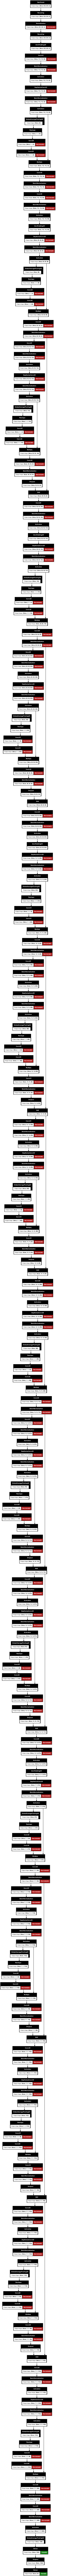

In [6]:
base_model = EfficientNetB0(
    include_top=False, weights="imagenet", input_tensor=Input(shape=(224, 224, 3))
)

# Ajout des couches personnalisées
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)  # taux de dropout à 0.5 pour réduire le surapprentissage
predictions = Dense(len(y_train_image.unique()), activation="softmax")(
    x
)  # ajustement du nombre de classes selon y_train

model_image = Model(inputs=base_model.input, outputs=predictions)

# Geler les couches du modèle pré-entraîné pour ne pas les ré-entraîner
for layer in base_model.layers:
    layer.trainable = False

utils.plot_model(model_image, show_shapes=True, show_trainable=True, dpi=50)

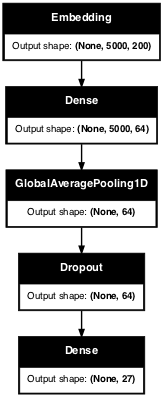

In [7]:
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=100000,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
vectorize_layer.adapt(X_train_text)
X_train_text = vectorize_layer(X_train_text)
X_test_text = vectorize_layer(X_test_text)

model_text = Sequential(
    [
        Embedding(len(vectorize_layer.get_vocabulary()), 200, mask_zero=True),
        Dense(64, activation="relu"),
        GlobalAveragePooling1D(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ]
)

model_text.build((None, sequence_length))
utils.plot_model(model_text, show_shapes=True, dpi=50)

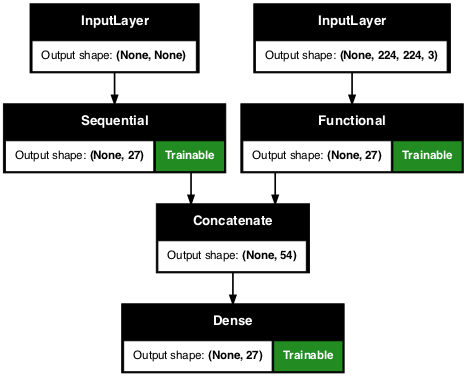

In [8]:
# Define a new input layer for text
text_input = Input(shape=(None,), name="text_input")

# Define a new input layer for images
image_input = Input(shape=(224, 224, 3), name="image_input")

# Use the text classification model to process the text input
text_output = model_text(text_input)

# Use the image classification model to process the image input
image_output = model_image(image_input)

# Concatenate the output of both models
combined_output = Concatenate()([text_output, image_output])

# Add a new output layer to make the final prediction
output = Dense(num_classes, activation="softmax")(combined_output)

# Define the multimodal model
multimodal_model = Model(inputs=[text_input, image_input], outputs=output)
utils.plot_model(multimodal_model, show_shapes=True, show_trainable=True, dpi=60)

In [9]:
# Compile the model
opt = optimizers.Adam(0.001)
loss = losses.CategoricalCrossentropy()
f1_score = metrics.F1Score(average="weighted")
multimodal_model.compile(
    optimizer=opt,
    loss=loss,
    metrics=["accuracy", f1_score],
)

In [16]:
X_train_text

<tf.Tensor: shape=(67932, 5000), dtype=int64, numpy=
array([[  146,    42,   502, ...,     0,     0,     0],
       [12582, 34716, 85807, ...,     0,     0,     0],
       [ 2343,  6612,   411, ...,     0,     0,     0],
       ...,
       [  179,     4,  1861, ...,     0,     0,     0],
       [ 1008,   998,  1385, ...,     0,     0,     0],
       [ 2719,   224,     2, ...,     0,     0,     0]])>

In [10]:
X_train_text = tf.convert_to_tensor(X_train_text)
X_test_text = tf.convert_to_tensor(X_test_text)
X_test_text

<tf.Tensor: shape=(16984, 1), dtype=string, numpy=
array([[b"Fullmetal Alchemist Figurine Riza Hawkeye 10 Cm Trading figurine d'une taille de 10 cm environ. En boite."],
       [b'Mebby Biberon Vetro 270ml Lattice Blu'],
       [b'Chaise De Plage Hwc-A11 Mer Du Nord B\xc3\xa2che Incluse   Beige Chaise de plage HWC-A11 mer du Nord b\xc3\xa2che incluse ~ beige<br /><br />- Livraison\xc2\xa0: Chaise de plage avec b\xc3\xa2che<br />- R\xc3\xa9glable en 5 \xc3\xa9chelons<br />- 2 si\xc3\xa8ges<br />- Vannerie en poly-rotin<br />- Peut s&#39;\xc3\xa9tendre<br />- Repose-pieds extensibles sur les deux c\xc3\xb4t\xc3\xa9s<br />- Repose-pieds \xc3\xa9lev\xc3\xa9s<br />- Porte-gobelet d\xc3\xa9pliable de chaque c\xc3\xb4t\xc3\xa9<br />- Poches int\xc3\xa9rieures<br />- 2 poign\xc3\xa9es de transport<br />- Housses de coussin avec fermetures \xc3\xa9clair 100 % polyester<br />- Housses amovibles et imperm\xc3\xa9ables<br />- 2 coussins d\xc3\xa9coratifs<br />- Coussins repose-t\xc3\xaate doux et 

In [10]:
# Callbacks
early_stopping = EarlyStopping(
    patience=4,  # Attendre n epochs avant application
    min_delta=0.0001,  # si au bout de n epochs la fonction de perte ne varie pas de n %,
    # que ce soit à la hausse ou à la baisse, on arrête
    verbose=1,  # Afficher à quel epoch on s'arrête
    monitor="val_loss",
    start_from_epoch=5,
)
reduce_learning_rate = ReduceLROnPlateau(
    monitor="val_loss",
    patience=2,  # si val_loss stagne sur n epochs consécutives selon la valeur min_delta
    min_delta=0.005,
    min_lr=0.00001,
    factor=0.1,  # On réduit le learning rate d'un facteur n
    cooldown=2,  # On attend n epochs avant de réitérer
    verbose=1,
)

# Train the model
training_history = multimodal_model.fit(
    {"text_input": X_train_text, "image_input": X_train_generator},
    y_train_text,
    epochs=20,
    batch_size=128 * 4,
    validation_data=(
        {"text_input": X_test_text, "image_input": X_test_generator},
        y_test_text,
    ),
    callbacks=[reduce_learning_rate, early_stopping],
    # class_weight=class_weight_dict,
)
plt_graph(training_history, None)

ValueError: Unrecognized data type: x={'text_input': <tf.Tensor: shape=(67932, 5000), dtype=int64, numpy=
array([[  146,    42,   502, ...,     0,     0,     0],
       [12582, 34716, 85807, ...,     0,     0,     0],
       [ 2343,  6612,   411, ...,     0,     0,     0],
       ...,
       [  179,     4,  1861, ...,     0,     0,     0],
       [ 1008,   998,  1385, ...,     0,     0,     0],
       [ 2719,   224,     2, ...,     0,     0,     0]])>, 'image_input': <keras.src.legacy.preprocessing.image.DataFrameIterator object at 0x11c470430>} (of type <class 'dict'>)

https://keras.io/examples/nlp/multimodal_entailment/#model-building-utilities